# Predicting Covid 19 using chest X-rays

### Context
Covid 19 has been cause of most deaths around the globe since the last one and a half years. COVID-19 is a disease caused by a new strain of coronavirus. 'CO' stands for corona, 'VI' for virus, and 'D' for disease. Formerly, this disease was referred to as '2019 novel coronavirus' or '2019-nCoV.'  

Current evidence suggests that the virus spreads mainly between people who are in close contact with each other, typically within 1 metre (short-range). A person can be infected when aerosols or droplets containing the virus are inhaled or come directly into contact with the eyes, nose, or mouth.

Detection of Covid-19 is done using RT-PCR tests, the major downside of this test is that it takes a long amount of time to get processed which thereby increases the chances of patient's degradation in health.
There is another process by which doctors are able to detect the presence of Corona virus, it is done using X-Rays. But during these times the availability of a doctor is also difficult to each and every person. So using DNN to train and predict Covid-19 will be of a great use.

### Data Set
The data set was taken from kaggle, the link to which is 
[COVIDx CXR-2 Dataset](https://www.kaggle.com/andyczhao/covidx-cxr2)  
The data set had 2 folders 
1. Train 
2. Test 

Train folder had 15971 X-ray images belonging to both the positive and negative classes, out of which 2158 were Covid-19 positive and 13792 were Covid-19 negative  
Test folder has 400 X-ray images, out of which 200 were Covid-19 positive and the other 200 were Covid-19 negative 

### Methodology
The data set is imbalanced, i.e. it has 2158 positive examples and 13792 negative examples.  In such a case we have two solutions, either 
1. Under sampling the data (taking same number of positive and negative samples, i.e. 2158 positive and 2158 negative)  
2. Over sampling the data (generating new positive samples in order to match the amount of negative samples)

When it comes to CNNs we have two options
1. Train our own model from scratch
2. Apply Transfer Learning on a pre trained model. 

First we'll take VGG-16 which is pre trained model that won the ImageNet challenge, the architecture is given below

![VGG16](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png) 

Next we'll make a CNN of our own and train it from scratch on our data set, I'll be sharing the architecture in the code 

So to check for accuracies in different model and pre processing, we will be training 3 models in total 

1. Transfer Learning on VGG-16 without Data Augmentation
2. Transfer Learning on VGG-16 with Data Augmentation
3. Training a CNN from scratch without Data Augmentation

#### For the accuracy of the test set, I'll be using my test images on the validation parameter instead of dividing my training data into two parts.

### Importing required libraries

In [58]:
import numpy as np
import pandas as pd
import warnings 
from sklearn.model_selection import train_test_split
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions 
import itertools 
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

### Loading the dataset's name and results text file 

In [121]:
df_test=pd.read_csv(r'C:\Users\User1\OneDrive\Desktop\CovidProject\test.txt',sep=" ")

In [122]:
df_test.head()

,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
0,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
1,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
2,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
3,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord
4,SITE2-000265,MIDRC-RICORD-1C-SITE2-000265-99793-1.png,positive,ricord


### Giving column names to the data

In [123]:
df_test.columns=["id","file name","class","data source"]

In [124]:
df_test.head()

,id,file name,class,data source
0,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
1,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
2,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
3,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord
4,SITE2-000265,MIDRC-RICORD-1C-SITE2-000265-99793-1.png,positive,ricord


In [125]:
df_train=pd.read_csv(r'C:\Users\User1\OneDrive\Desktop\CovidProject\train.txt',sep=" ")

In [126]:
df_train.columns=["id","file name","class","data source"]

### Checking for null values 

In [127]:
df_train.isnull().sum()

id             0
file name      0
class          0
data source    0
dtype: int64

In [128]:
df_test.isnull().sum()

id             0
file name      0
class          0
data source    0
dtype: int64

In [129]:
df_train["class"].unique()

array(['negative', 'positive'], dtype=object)

In [130]:
df_train["class"].value_counts()

negative    13792
positive     2158
Name: class, dtype: int64

In [131]:
df_test["class"].value_counts()

negative    200
positive    199
Name: class, dtype: int64

## 1-Transfer Learning on VGG-16 without Data Augmentation

### Making another data frame with all the negative samples

In [132]:
df_train_negative=df_train[df_train["class"]=="negative"]
df_train_negative.shape

(13792, 4)

In [133]:
df_train.drop(df_train[df_train["class"]=="negative"].index,inplace=True)

In [135]:
df_train["class"].value_counts()

positive    2158
Name: class, dtype: int64

### Randomly sampling data from negative samples to equal the number of positive samples 

In [136]:
df_train_negative=df_train_negative.sample(n=2158,replace=False,random_state=5)

In [138]:
df_train_negative["class"].value_counts()

negative    2158
Name: class, dtype: int64

### Concatinating the positive and negative samples 

In [139]:
df_train_reduced=pd.concat([df_train,df_train_negative],axis=0)

In [140]:
df_train_reduced["class"].value_counts()

negative    2158
positive    2158
Name: class, dtype: int64

In [141]:
df_train_reduced=df_train_reduced.sample(frac=1)

### Re-shuffling positve and negative samples 

In [143]:
df_train=df_train_reduced

In [144]:
df_train["class"].value_counts()

negative    2158
positive    2158
Name: class, dtype: int64

### Dropping unnecessary columns from the data set

In [146]:
df_test.drop(["id","data source"],axis=1,inplace=True)

In [147]:
df_train.drop(["id","data source"],axis=1,inplace=True)

In [148]:
df_train.head()

,file name,class
1905,MIDRC-RICORD-1C-SITE2-000251-01666-0.png,positive
2512,MIDRC-RICORD-1C-SITE2-000251-96070-0.png,positive
3217,35412b65-c05b-4b5d-b97c-e4c7b6e8211d.png,negative
1010,COVID(306).png,positive
539,covid-19-pneumonia-progression-and-regression-...,positive


In [149]:
df_test.head()

,file name,class
0,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
1,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
2,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
3,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive
4,MIDRC-RICORD-1C-SITE2-000265-99793-1.png,positive


### Importing the VGG-16 model along with the weights for transfer learning 

In [45]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [46]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Setting the training of all the layers in the base model to False and using the pre trained weights

In [47]:
for layer in base_model.layers:
    layer.trainable = False

### Copying the files from the training data folder to 2 different folders names 'positive' and 'negative' under the main training folder 

In [48]:
s="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train\\"

In [152]:
import shutil, os
for (f,c) in zip(df_train["file name"],df_train["class"]):
        if c=="positive":
            shutil.copy(s+f, 'C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train_final\\positive')
        else:
            shutil.copy(s+f, 'C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train_final\\negative')

### Re-scaling the RGB values between 0-1 for faster training and better accuracy

In [49]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [50]:
train_dir="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train_final"
validation_dir="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\validation"

### Initialising Image generator for feeding training and validation image samples to the model

In [51]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 50, class_mode = 'binary', target_size = (224, 224))

Found 4316 images belonging to 2 classes.


In [52]:
validation_generator = valid_datagen.flow_from_directory( validation_dir,  batch_size = 50, class_mode = 'binary', target_size = (224, 224))

Found 400 images belonging to 2 classes.


### Adding layers in the end to classify images as positive and negative (Binary Classification) using sigmoid function

In [53]:

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [54]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Training

In [55]:
vgghist = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 87, epochs = 10)

Epoch 1/10
87/87 [==============================] - 801s 9s/step - loss: 0.5236 - acc: 0.7743 - val_loss: 0.2598 - val_acc: 0.8975
Epoch 2/10
87/87 [==============================] - 808s 9s/step - loss: 0.2920 - acc: 0.8784 - val_loss: 0.2137 - val_acc: 0.9175
Epoch 3/10
87/87 [==============================] - 837s 10s/step - loss: 0.2369 - acc: 0.9034 - val_loss: 0.1708 - val_acc: 0.9350
Epoch 4/10
87/87 [==============================] - 804s 9s/step - loss: 0.2028 - acc: 0.9189 - val_loss: 0.1530 - val_acc: 0.9425
Epoch 5/10
87/87 [==============================] - 803s 9s/step - loss: 0.1827 - acc: 0.9275 - val_loss: 0.1434 - val_acc: 0.9500
Epoch 6/10
87/87 [==============================] - 803s 9s/step - loss: 0.1706 - acc: 0.9314 - val_loss: 0.1712 - val_acc: 0.9425
Epoch 7/10
87/87 [==============================] - 803s 9s/step - loss: 0.1509 - acc: 0.9472 - val_loss: 0.4429 - val_acc: 0.8600
Epoch 8/10
87/87 [==============================] - 826s 9s/step - loss: 0.1420 - 

### Plotting Training and Validation accuracy and loss

In [56]:
train_acc= vgghist.history['acc']
train_loss = vgghist.history['loss']
valid_acc= vgghist.history['val_acc']
valid_loss= vgghist.history['val_loss']

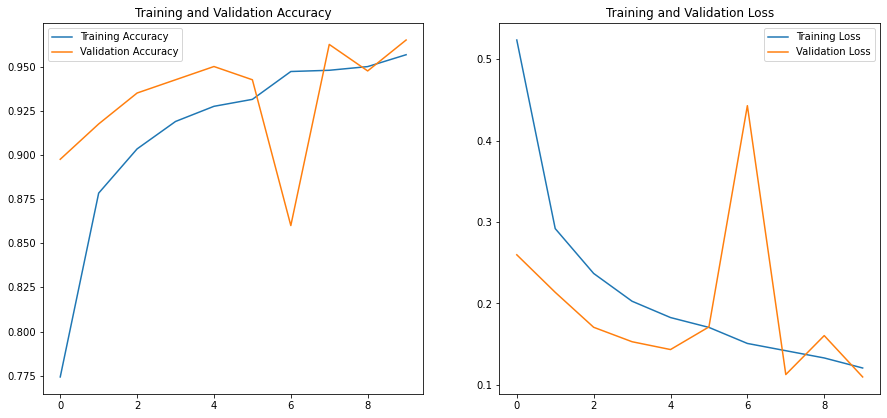

In [57]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#### The accuracy begins with 77% and goes up to 95.67% in the last epoch and on the test set we have a max. accuracy of 96.5%.  Because of Transfer Learning we are able to get such high accuracies even without Data Augmentation

In [68]:
model.save("model_vgg.h5")

## 2-Transfer Learning on VGG-16 with Data Augmentation

### Loading the data set again with all samples

In [16]:
df_train_VGG_A=pd.read_csv(r'C:\Users\User1\OneDrive\Desktop\CovidProject\train.txt',sep=" ")

In [17]:
df_train_VGG_A.columns=["id","file name","class","data source"]

In [18]:
df_train_VGG_A.drop(["id","data source"],axis=1,inplace=True)

In [19]:
df_train_VGG_A.head()

,file name,class
0,acute-respiratory-distress-syndrome-ards-1.jpg,negative
1,acute-respiratory-distress-syndrome-ards.jpg,negative
2,ards-secondary-to-tiger-snake-bite.png,negative
3,pneumocystis-pneumonia-2-PA.png,negative
4,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,negative


### Giving ImageDataGenerator parameters for doing Data Augmentation

1. Rotation Range of 20 degrees which is close to human error while taking photos
2. width_shift_range 0f .1 for minor horizontal shifts 
3. height_shift_range of .1 for minor vertical shifts
4. zoom range of .1 for minor zoomed in images 

In [20]:
datagen = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1)

In [25]:
df_train_VGG_A.drop(df_train_VGG_A[df_train_VGG_A["class"]=="negative"].index,inplace=True)

### Giving Image Generator images in batches of 1000 and saving the generated images

( Because my RAM was over flowing after 1K images at a go)

In [12]:
df_train_VGG_A_0_1000=df_train_VGG_A[:1000]

In [26]:
df_train_VGG_A_1000_2000=df_train_VGG_A[1000:2000]

In [11]:
df_train_VGG_A_2000_2158=df_train_VGG_A[2000:2159]

In [28]:
t='C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train\\'
for f in df_train_VGG_A_0_1000['file name']:
    img=load_img(t+f)
    x=img_to_array(img)
    x=x.reshape((1,)+x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size = 1,
                          save_to_dir ='C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train_augmented', 
                          save_prefix =(f[:len(f)-5]+str(i)), save_format ='jpeg'):
            i += 1
            if i > 5:
                break

### Importing the VGG-16 model along with the weights for transfer learning  

In [33]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [34]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Setting the training of all the layers in the base model to False and using the pre trained weights

In [35]:
for layer in base_model.layers:
    layer.trainable = False

### Re-scaling the RGB values between 0-1 for faster training and better accuracy

In [36]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

### Initialising Image generator for feeding training and validation image samples to the model

In [37]:
train_dir="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train_final_DA"
validation_dir="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\validation"

In [38]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 23586 images belonging to 2 classes.


In [39]:
validation_generator = valid_datagen.flow_from_directory(validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 400 images belonging to 2 classes.


### Adding layers in the end to classify images as positive and negative (Binary Classification) using sigmoid function

In [40]:

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model_vgg_da = tf.keras.models.Model(base_model.input, x)

model_vgg_da.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [41]:
model_vgg_da.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Training

In [42]:
vgg_A_hist = model_vgg_da.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 117, epochs = 10)

Epoch 1/10
117/117 [==============================] - 478s 4s/step - loss: 0.3686 - acc: 0.8500 - val_loss: 0.7056 - val_acc: 0.7300
Epoch 2/10
117/117 [==============================] - 481s 4s/step - loss: 0.1809 - acc: 0.9295 - val_loss: 0.3480 - val_acc: 0.8650
Epoch 3/10
117/117 [==============================] - 476s 4s/step - loss: 0.1277 - acc: 0.9474 - val_loss: 0.6122 - val_acc: 0.8025
Epoch 4/10
117/117 [==============================] - 488s 4s/step - loss: 0.1447 - acc: 0.9474 - val_loss: 0.7788 - val_acc: 0.7575
Epoch 5/10
117/117 [==============================] - 477s 4s/step - loss: 0.1194 - acc: 0.9594 - val_loss: 0.7666 - val_acc: 0.7875
Epoch 6/10
117/117 [==============================] - 477s 4s/step - loss: 0.1144 - acc: 0.9590 - val_loss: 0.6471 - val_acc: 0.8025
Epoch 7/10
117/117 [==============================] - 476s 4s/step - loss: 0.1126 - acc: 0.9583 - val_loss: 0.7285 - val_acc: 0.7875
Epoch 8/10
117/117 [==============================] - 476s 4s/step - 

### Plotting Training and Validation accuracy and loss

In [43]:
train_acc= vgg_A_hist.history['acc']
train_loss = vgg_A_hist.history['loss']
valid_acc= vgg_A_hist.history['val_acc']
valid_loss= vgg_A_hist.history['val_loss']

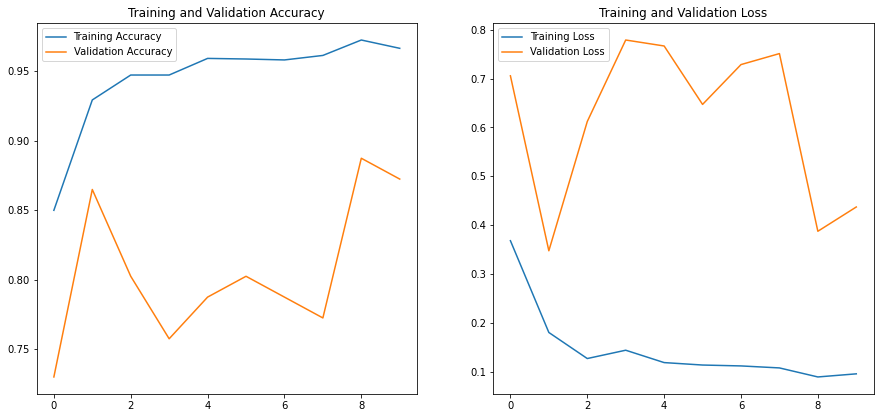

In [44]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#### Accuracy on the training set started from 85% and went up to 96.67%, on the test set we had a max. accuracy of 87.25%.  As per the theory we should have got an increase in the accuracy after data augmentation, but that wasn't the case. My prediction being that-We generated around 10K positive samples from 2158 samples so the model might have over fitted and hence a reduced accuracy

In [67]:
model_vgg_da.save("model_vgg_da.h5")

## 3-Training a CNN from scratch without Data Augmentation

### Iniatialising a sequential model

In [2]:
model_cnn=Sequential()

### Adding the required layers

In [3]:
    model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
    model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))

    model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))

    model_cnn.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model_cnn.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))

    model_cnn.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model_cnn.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    
    model_cnn.add(Flatten())
    model_cnn.add(Dense(512, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(1, activation='sigmoid'))

In [4]:
model_cnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [5]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

### Re-scaling the RGB values between 0-1 for faster training and better accuracy

In [6]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

### Initialising Image generator for feeding training and validation image samples to the model

In [7]:
train_dir="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\train_final"
validation_dir="C:\\Users\\User1\\OneDrive\\Desktop\\CovidProject\\validation"

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 50, class_mode = 'binary', target_size = (224, 224))

Found 4316 images belonging to 2 classes.


In [9]:
validation_generator = valid_datagen.flow_from_directory(validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 400 images belonging to 2 classes.


### Training

In [10]:
trialmodel = model_cnn.fit(train_generator, validation_data = validation_generator, steps_per_epoch=86, epochs = 10)

Epoch 1/10
86/86 [==============================] - 2008s 23s/step - loss: 0.6286 - acc: 0.6564 - val_loss: 0.5628 - val_acc: 0.7325
Epoch 2/10
86/86 [==============================] - 2023s 24s/step - loss: 0.4887 - acc: 0.7797 - val_loss: 0.4747 - val_acc: 0.8075
Epoch 3/10
86/86 [==============================] - 2004s 23s/step - loss: 0.4048 - acc: 0.8242 - val_loss: 0.4278 - val_acc: 0.8350
Epoch 4/10
86/86 [==============================] - 1993s 23s/step - loss: 0.3433 - acc: 0.8589 - val_loss: 0.3306 - val_acc: 0.8750
Epoch 5/10
86/86 [==============================] - 2017s 23s/step - loss: 0.3058 - acc: 0.8779 - val_loss: 0.3243 - val_acc: 0.8725
Epoch 6/10
86/86 [==============================] - 2025s 24s/step - loss: 0.2806 - acc: 0.8875 - val_loss: 0.2806 - val_acc: 0.8900
Epoch 7/10
86/86 [==============================] - 2044s 24s/step - loss: 0.2417 - acc: 0.9076 - val_loss: 0.2609 - val_acc: 0.9100
Epoch 8/10
86/86 [==============================] - 2000s 23s/step - 

### Plotting Training and Validation accuracy and loss

In [11]:
train_acc=trialmodel.history['acc']
train_loss = trialmodel.history['loss']
valid_acc=trialmodel.history['val_acc']
valid_loss=trialmodel.history['val_loss']

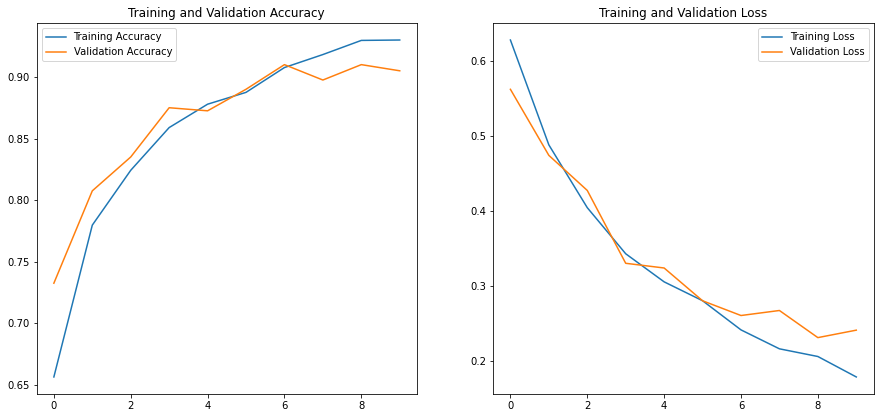

In [12]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#### Accuracy on the training set started from 65.64% and went up to 93% and on the test set max. accuracy was 91%

In [66]:
model_cnn.save("model_cnn.h5")

| Model       |Train Accuracy | Test Accuracy|
| :---        |    :----:   |          ---: |
| VGG-16 without data augmentation     | 95.67%       | 96.5%   |
| VGG-16 with data augmentation   | 96.67%     | 87.25%      |
| CNN from scratch                |    93%              |       91%         |

## Best Accuracy was given by VGG-16 without using Data Augmentation